<a href="https://colab.research.google.com/github/DUNGTK2004/deep-models-from-scratch/blob/main/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import dependencies

In [78]:
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms as T
import matplotlib.pyplot as plt
import numpy as np
import time
import tqdm


### Load data

In [95]:
batch_size = 64
transform = T.Compose([
    T.ToTensor(),
    # T.Lambda(lambda x: x.repeat(3, 1, 1)),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


In [96]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [97]:
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False, num_workers=2)

### Model pretrained ViT



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
# for parameter in pretrained_vit.parameters():
#   parameter.requires_grad = False

pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 56.7MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
model = pretrained_vit
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

86567656


### ViT from scratch

In [98]:
def img_to_patch(x, patch_size, flatten_channels=True):
  B, C, H, W = x.shape
  x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size) # B, C, H', P, W', P
  x = x.permute(0, 2, 4, 1, 3, 5) # B, H', W', C, P, P
  x = x.flatten(1, 2)             # B, H' * W', C, P, P
  if flatten_channels:
    x = x.flatten(2, 4)           # B, H' * W', C * P * P
  return x

Visualize the patches of image

torch.Size([1, 1, 28, 28])
1 1 28 28 7
torch.Size([1, 16, 1, 7, 7])


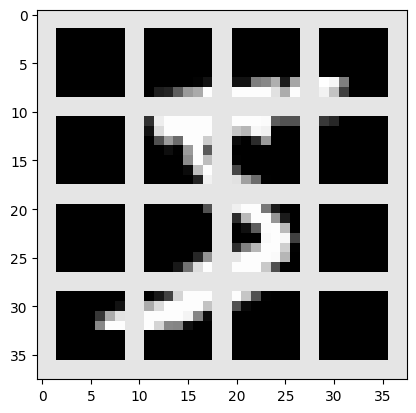

In [ ]:
image = mnist_trainset[0][0].unsqueeze(0)
_, C, H, W = image.shape
print(image.shape)
img_patches = img_to_patch(image, patch_size=7, flatten_channels=False)
img_grid = torchvision.utils.make_grid(img_patches[0], nrow=H//7, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)
plt.imshow(img_grid)


Test multihead attention from scratch but not efficiently

In [66]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, head_size, dropout=0.1):
    super().__init__()
    self.head_size = head_size
    self.query = nn.Linear(d_model, head_size, bias=False)
    self.key = nn.Linear(d_model, head_size, bias=False)
    self.value = nn.Linear(d_model, head_size, bias=False)
    self.dropout = nn.Dropout(dropout)
  def forward(self, x):
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    attention = Q @ K.transpose(-2, -1)
    attention = attention / (self.head_size ** 0.5)
    attention = torch.softmax(attention, dim=-1)
    attention= self.dropout(attention)
    attention = attention @ V

    # attention = F.scaled_dot_product_attention(Q, K, V, dropout_p=0.1)

    return attention

In [67]:
class MultiheadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.head_size = d_model // n_heads

    self.W_o = nn.Linear(d_model, d_model)
    self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])
    self.layer_norm = nn.LayerNorm(d_model)
  def forward(self, x):
    out = torch.cat([head(x) for head in self.heads], dim=-1)
    out = self.W_o(out)
    return self.layer_norm(out)


In [99]:
class AttentionBlock(nn.Module):
  def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embed_dim)
    self.mha = nn.MultiheadAttention(embed_dim, num_heads)
    self.layer_norm2 = nn.LayerNorm(embed_dim)
    self.mlp = nn.Sequential(
        nn.Linear(embed_dim, hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, embed_dim),
        nn.Dropout(dropout)
    )

  def forward(self, x):
    input = self.layer_norm1(x)
    x = x + self.mha(input, input, input)[0]
    x = x + self.mlp(self.layer_norm2(x))
    return x

In [100]:
class VisionTransformer(nn.Module):
  def __init__(self, num_channel, patch_size, embed_dim, num_patch,
               hidden_dim, num_heads, num_layers, num_classes, dropout=0.0):
    super().__init__()

    self.patch_size = patch_size

    self.input_layer = nn.Linear(num_channel * (patch_size ** 2), embed_dim) # because output of patch image layer is num_channels * (P ** 2)
    self.cls_token = nn.Parameter(torch.rand(1, 1, embed_dim))
    self.position_embedding = nn.Parameter(torch.rand(1, 1 + num_patch, embed_dim))

    self.transformer_encoder = nn.Sequential(
        *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout) for _ in range(num_layers))
    )
    self.mlp = nn.Sequential(
        nn.LayerNorm(embed_dim),
        nn.Linear(embed_dim, num_classes)
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = img_to_patch(x, self.patch_size, flatten_channels=True) # batch, num_patch, (c * patch_size ** 2)
    B, N, _ = x.shape
    x = self.input_layer(x)

    cls_token = self.cls_token.repeat(B, 1, 1)
    x = torch.cat([cls_token, x], dim=1)
    x = x + self.position_embedding[:, : N + 1]

    x = self.dropout(x)
    x = x.transpose(1, 0) # -> num_patch+1, batch_size, embed để phù hợp với output transformer
    x = self.transformer_encoder(x)
    cls_token = x[0]
    x = self.mlp(cls_token)
    x = self.dropout(x)
    return x


In [102]:
# parameter
num_channel = 1
patch_size = 7
embed_dim = 256
num_patch = 16
hidden_dim = embed_dim * 3
num_heads = 8
num_layers = 6
num_classes = 10
dropout = 0.2

In [103]:
model = VisionTransformer(num_channel=num_channel, patch_size=patch_size,
                          embed_dim=embed_dim, num_patch=num_patch,
                          hidden_dim=hidden_dim, num_heads=num_heads,
                          num_layers=num_layers, num_classes=num_classes,
                          dropout=dropout)

In [43]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

3971082


In [53]:
model

VisionTransformer(
  (input_layer): Linear(in_features=49, out_features=256, bias=True)
  (transformer_encoder): Sequential(
    (0): AttentionBlock(
      (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=768, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm2): LayerN

### Train/test

In [11]:
def test_accuracy(data_iter, net):
  acc_sum, n = 0, 0
  for (imgs, labels) in data_iter:
    # send data to the GPU if cuda is available
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    net.eval()
    with torch.no_grad():
      labels = labels.long()
      acc_sum += torch.sum((torch.argmax(net(imgs), dim=1) == labels)).float()
      n += labels.shape[0]

  return acc_sum.item()/n

In [104]:
if torch.cuda.is_available():
 model =model.cuda()

opt = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)

criterion = nn.CrossEntropyLoss()

model_scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[10, 20], gamma=0.1)


for epoch in range(0, 10):
  n, start = 0, time.time()
  train_l_sum = torch.tensor([0.0], dtype=torch.float32)
  train_acc_sum = torch.tensor([0.0], dtype=torch.float32)
  for i, (imgs, labels) in tqdm.tqdm(enumerate(mnist_trainloader)):
    model.train()
    # If training on GPU
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
      train_l_sum = train_l_sum.cuda()
      train_acc_sum = train_acc_sum.cuda()

    opt.zero_grad()

    # loss function
    output =model(imgs)

    loss = criterion(output, labels)
    loss.backward()
    opt.step()

    # Calculate training error
    model.eval()
    labels = labels.long()
    train_l_sum += loss.float()
    train_acc_sum += (torch.sum((torch.argmax(output, dim=1) == labels))).float()
    n += labels.shape[0]
  model_scheduler.step()
  test_acc = test_accuracy(iter(mnist_testloader),model)
  print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec' \
        % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc, time.time()-start))

938it [00:26, 35.72it/s]


epoch 1, loss 0.0207, train acc 0.536, test acc 0.828, time 28.8 sec


938it [00:23, 39.13it/s]


epoch 2, loss 0.0130, train acc 0.713, test acc 0.875, time 26.3 sec


938it [00:24, 39.08it/s]


epoch 3, loss 0.0101, train acc 0.769, test acc 0.911, time 26.1 sec


938it [00:23, 39.26it/s]


epoch 4, loss 0.0094, train acc 0.780, test acc 0.899, time 25.9 sec


938it [00:24, 38.95it/s]


epoch 5, loss 0.0087, train acc 0.796, test acc 0.922, time 26.1 sec


938it [00:24, 38.39it/s]


epoch 6, loss 0.0094, train acc 0.782, test acc 0.909, time 26.7 sec


938it [00:23, 39.31it/s]


epoch 7, loss 0.0084, train acc 0.799, test acc 0.926, time 26.4 sec


938it [00:24, 38.97it/s]


epoch 8, loss 0.0086, train acc 0.795, test acc 0.917, time 26.1 sec


938it [00:23, 39.39it/s]


epoch 9, loss 0.0084, train acc 0.799, test acc 0.917, time 25.8 sec


938it [00:23, 39.37it/s]


epoch 10, loss 0.0084, train acc 0.800, test acc 0.903, time 25.8 sec
